In [1]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Data Pre-processing
import pandas as pd
from sklearn.model_selection import KFold

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

# Configuration
py.init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
samples=[]
sample_rates=[]
labels = []

gunshot_sound_dir = "/home/alexm/Datasets/gunshot_data/gunshot/"

for file in os.listdir(gunshot_sound_dir):
    if file.endswith(".wav"):
        try:
            sample_rate, sample = wavfile.read(gunshot_sound_dir + file)
            sample = sample[:,0]
            for i in range(0, sample.size - 30000, 10000):
                sample_slice = sample[i : i + 30000]
                label = 2
                if np.max(abs(sample_slice)) < 500.0:
                    label = 0

                samples.append(sample_slice)
                sample_rates.append(sample_rate)
                labels.append(label)
        except:
            pass
        
glassbreak_sound_dir = "/home/alexm/Datasets/gunshot_data/glassbreak/"

for file in os.listdir(glassbreak_sound_dir):
    if file.endswith(".wav"):
        try:
            sample_rate, sample = wavfile.read(glassbreak_sound_dir + file)
            sample = sample[:,0]
            for i in range(0, sample.size - 30000, 10000):
                sample_slice = sample[i : i + 30000]
                label = 1
                if np.max(abs(sample_slice)) < 500.0:
                    label = 0

                samples.append(sample_slice)
                sample_rates.append(sample_rate)
                labels.append(label)
        except:
            pass

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

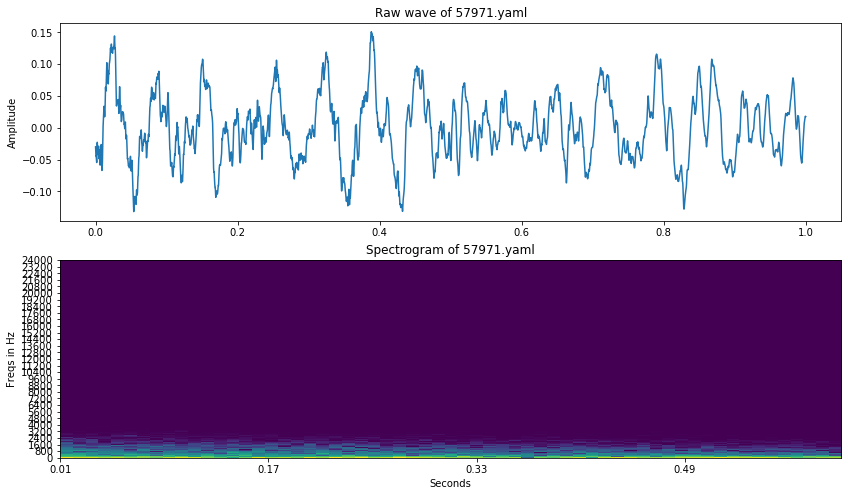

In [4]:
i=15
samp=samples[i]
sr=sample_rates[i]

freqs, times, spectrogram = log_specgram(samp, sr)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 1,samp.size), samp)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [5]:
i=2
samp=samples[i]
sr=sample_rates[i]
print(labels[i])
ipd.Audio(samp, rate=sr)

0


In [6]:
kf = KFold(n_splits=3, shuffle=True)
samples = np.array(samples)
labels = np.array(labels)
for train_index, test_index in kf.split(samples):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_wav, test_wav = samples[train_index], samples[test_index]
    train_label, test_label = labels[train_index], labels[test_index]

TRAIN: [   0    1    2 ... 2116 2120 2121] TEST: [   9   13   15   25   26   27   28   29   30   31   32   33   37   38
   44   45   50   55   64   67   69   72   79   80   82   83   84   85
   86   91   93   94   95   99  103  104  107  111  113  115  119  120
  124  126  131  139  143  145  147  150  153  161  164  165  167  169
  170  173  180  181  183  185  186  187  189  190  192  193  194  198
  201  205  206  211  213  214  216  217  224  227  228  229  230  231
  239  245  251  254  255  260  262  269  270  271  275  278  282  287
  288  292  296  301  305  306  312  316  318  324  325  327  330  334
  337  341  343  346  348  360  361  363  364  369  371  372  373  376
  377  382  387  390  392  396  397  400  403  407  409  413  417  419
  422  428  432  436  439  441  445  451  455  459  468  471  475  476
  478  481  484  485  486  493  494  496  506  510  512  516  520  521
  524  534  535  536  540  543  545  547  548  555  556  560  562  564
  567  568  570  571  572  5

In [7]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 256
drop_out_rate = 0.2
input_shape = (30000,1)

In [8]:
#For Conv1D add Channel
train_wav = np.array(train_wav)
test_wav = np.array(test_wav)
train_wav = train_wav.reshape(-1,30000,1)
test_wav = test_wav.reshape(-1,30000,1)
train_label = keras.utils.to_categorical(train_label, 3)
test_label = keras.utils.to_categorical(test_label, 3)

In [9]:
print(train_wav.shape)

(1415, 30000, 1)


In [10]:
input_tensor = Input(shape=input_shape)

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(256, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation='relu')(x)
output_tensor = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 29990, 8)          96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14995, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14989, 16)         912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3747, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3743, 32)          2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 935, 32)           0         
__________

In [12]:
model.fit(train_wav, train_label, 
          validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=50,
          verbose=1)

Train on 1415 samples, validate on 707 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1415/1415 [==============================] - 6s 4ms/sample - loss: 6.0507 - acc: 0.4071 - val_loss: 4.6402 - val_acc: 0.4738
Epoch 2/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 5.4885 - acc: 0.4544 - val_loss: 4.3545 - val_acc: 0.5149
Epoch 3/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 5.0742 - acc: 0.4671 - val_loss: 3.7439 - val_acc: 0.4767
Epoch 4/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 4.5611 - acc: 0.4763 - val_loss: 4.1952 - val_acc: 0.4752
Epoch 5/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 4.1777 - acc: 0.5117 - val_loss: 2.9157 - val_acc: 0.6294
Epoch 6/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 3.1675 - acc: 0.6191 - val_loss: 2.2552 - val_acc: 0.7313
Epoch 7/50
1415/1415 [==============================] - 3s 2ms/sample - loss: 2.2134 - ac

In [20]:
Y_test_pred = model.predict(test_wav)
y_classes = Y_test_pred.argmax(axis=-1)
y_test= test_label.argmax(axis=-1)
wrong_examples = np.nonzero(y_classes != y_test)

In [21]:
print(wrong_examples)

(array([ 18,  20,  22,  27, 122, 123, 129, 130, 131, 144, 149, 150, 154,
       156, 176, 182, 193, 196, 197, 198, 200, 252, 261, 262, 263, 289,
       293, 315, 323, 328, 373, 418, 428, 430, 431, 432, 461, 473, 487,
       494, 497, 498, 519, 524, 529, 555, 594, 597, 598, 635, 636, 642,
       648, 667, 681, 703]),)


In [15]:
i=2
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [9.9479574e-01 5.1240423e-03 8.0242782e-05]


In [16]:
i=10
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [0.7078607  0.18181685 0.11032244]


In [17]:
i=44
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [0.9313842  0.06127589 0.00733979]


In [18]:
i=60
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [5.9865852e-06 5.2870007e-07 9.9999344e-01]


In [19]:
i=20
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [0.7274393  0.1795184  0.09304236]
